<h1> Attempt to model available bikes and docks. </h1>

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pylab as pl

In [2]:
pl.rcParams.update({'font.size':22,
                    'figure.figsize':(12,8)})

In [39]:
# Load Data.
puma = pd.read_csv('puma_3810.csv', index_col=0)
puma = puma.dropna() # drop nans.

In [38]:
puma.head(4)

,dayofyear,dayofweek,hour,avail_bikes,avail_docks,in_service,avail_bikes-1,avail_bikes-2,avail_bikes-3,avail_bikes-4,avail_bikes-5,avail_docks-1,avail_docks-2,avail_docks-3,avail_docks-4,avail_docks-5,tot_docks,tot_stations
2018-01-01 00:00:00,1.0,0.0,0.0,827.0,1729.5,73.0,811.0,791.0,782.0,780.0,782.5,1748.0,1770.0,1779.0,1769.0,1778.5,2586,80
2018-01-01 01:00:00,1.0,0.0,1.0,811.0,1748.0,73.0,791.0,782.0,780.0,782.5,780.0,1770.0,1779.0,1769.0,1778.5,1781.0,2586,80
2018-01-01 02:00:00,1.0,0.0,2.0,791.0,1770.0,73.0,782.0,780.0,782.5,780.0,NaN,1779.0,1769.0,1778.5,1781.0,NaN,2586,80
2018-01-01 03:00:00,1.0,0.0,3.0,782.0,1779.0,73.0,780.0,782.5,780.0,NaN,NaN,1769.0,1778.5,1781.0,NaN,NaN,2586,80


In [40]:
# Split into test and train.
split_date = '2018-06-15'
train = puma[:split_date]
test = puma[split_date:]

In [41]:
# Error Metrics.
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

<h2> Baseline error estiamte. </h2>

In [42]:
rmse(train.avail_bikes, train['avail_bikes-1'])

90.18094494281404

In [43]:
rmsle(train.avail_bikes, train['avail_bikes-1'])

0.08312578639901151

<h2> Train set and test set. </h2>

In [44]:
X = train.drop(columns=['avail_bikes', 'avail_docks'])
Y = train['avail_bikes'].values

<h2> Bike modeling. </h2>

In [45]:
bike_mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
bike_mdl.fit(X.values, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [46]:
bike_hat = bike_mdl.predict(X)

In [47]:
print(rmse(train.avail_bikes, bike_hat))
print(rmsle(train.avail_bikes, bike_hat))

18.68280379747815
0.08260136341030448


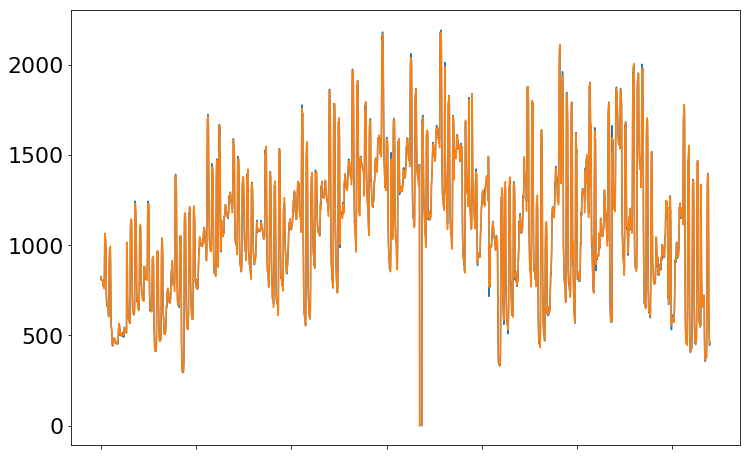

In [48]:
fig, ax = pl.subplots()
train.avail_bikes.plot()
ax.plot(bike_hat);

In [49]:
importances = bike_mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in bike_mdl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [50]:
print("Feature ranking:")

col_names = list(train.columns)
col_names.remove('avail_bikes')
for f in range(X.shape[1]):
    print("{}. feature {}: {} ({})".format(f + 1, indices[f], X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature 4: dayofyear (0.9442319976545109)
2. feature 5: dayofweek (0.016517710909304328)
3. feature 2: hour (0.010583672134490013)
4. feature 9: in_service (0.0056132935226260155)
5. feature 10: avail_bikes-1 (0.004278272308477968)
6. feature 6: avail_bikes-2 (0.0034586713495186254)
7. feature 11: avail_bikes-3 (0.0026054289680410053)
8. feature 7: avail_bikes-4 (0.002519225168701998)
9. feature 0: avail_bikes-5 (0.0022707816170623105)
10. feature 8: avail_docks-1 (0.0021790055615688014)
11. feature 1: avail_docks-2 (0.0012130903317338134)
12. feature 14: avail_docks-3 (0.0012119724470214235)
13. feature 12: avail_docks-4 (0.0012009944346171092)
14. feature 13: avail_docks-5 (0.00108017963575513)
15. feature 3: tot_docks (0.0006891120961273718)
16. feature 15: tot_stations (0.00034659186044281963)


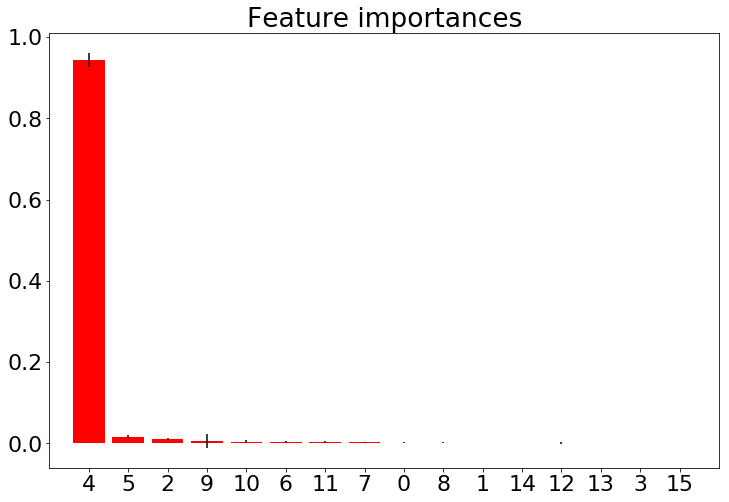

In [51]:
# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(X.shape[1]), indices)
pl.xlim([-1, X.shape[1]])
pl.show()

<h2> Dock modeling. </h2>

In [17]:
X = train.drop(columns=['avail_bikes', 'avail_docks'])
Y = train['avail_docks'].values

In [18]:
dock_mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
dock_mdl.fit(X.values, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
dock_hat = dock_mdl.predict(X)

In [20]:
print(rmse(train.avail_docks, dock_hat))
print(rmsle(train.avail_docks, dock_hat))

19.01299985815477
0.015003771600142463


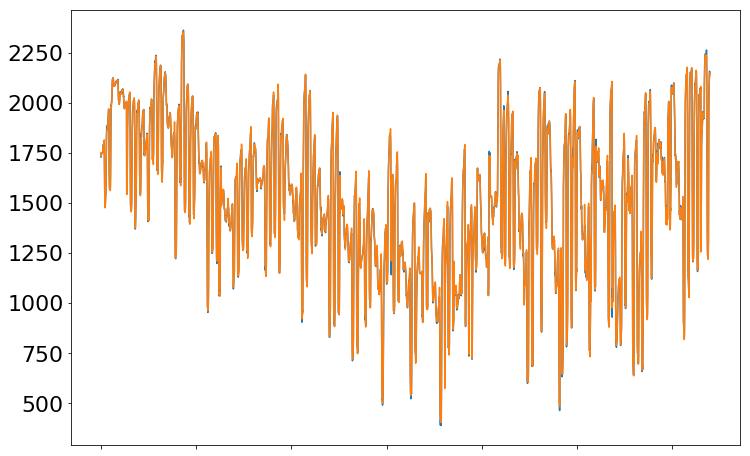

In [21]:
fig, ax = pl.subplots()
train.avail_docks.plot()
ax.plot(dock_hat);

In [22]:
importances = dock_mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in dock_mdl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [23]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("{}. feature {}: {} ({})".format(f + 1, indices[f], X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature 9: dayofyear (0.9439429147311377)
2. feature 10: dayofweek (0.015394378396801554)
3. feature 2: hour (0.009902823739188528)
4. feature 4: in_service (0.006365825023803747)
5. feature 5: avail_bikes-1 (0.005183277955559702)
6. feature 11: avail_bikes-2 (0.0043727789943047825)
7. feature 0: avail_bikes-3 (0.0026187905257369143)
8. feature 6: avail_bikes-4 (0.00219172003505006)
9. feature 13: avail_bikes-5 (0.001974352320867813)
10. feature 12: avail_docks-1 (0.0019186761344315202)
11. feature 14: avail_docks-2 (0.001393870877779476)
12. feature 8: avail_docks-3 (0.0013416916548376781)
13. feature 7: avail_docks-4 (0.0013201017572717012)
14. feature 1: avail_docks-5 (0.0009936773690280135)
15. feature 3: tot_docks (0.0007099951789614718)
16. feature 15: tot_stations (0.0003751253052411462)


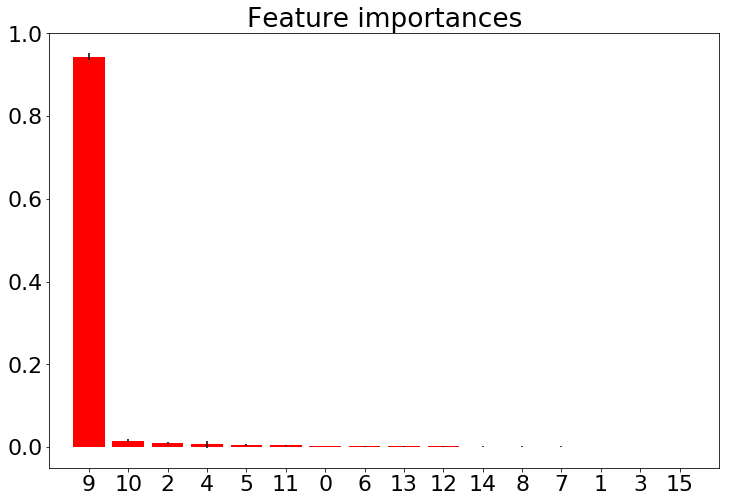

In [24]:
# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(X.shape[1]), indices)
pl.xlim([-1, X.shape[1]])
pl.show()

<h2> Evaluation on test set. </h2>

In [25]:
X = test.drop(columns=['avail_bikes', 'avail_docks'])
Y = test['avail_bikes'].values

In [26]:
X.shape

(889, 16)

In [27]:
Y.shape

(889,)

In [28]:
bikes_test_hat = bike_mdl.predict(X.values)

In [29]:
rmse(Y, bikes_test_hat)

64.5124173544155

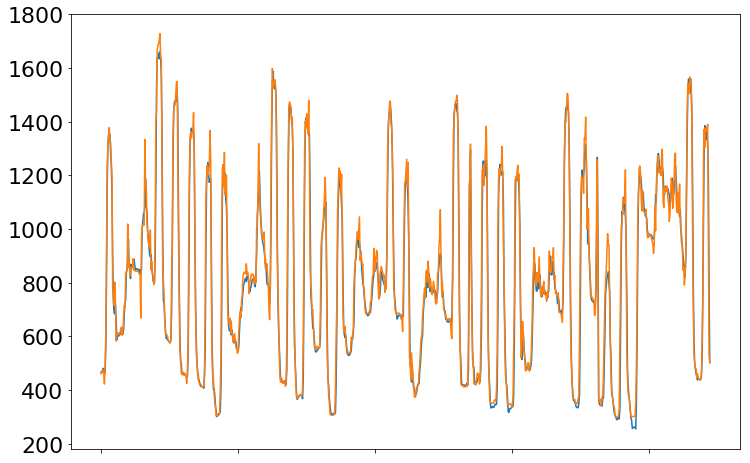

In [30]:
fig, ax = pl.subplots()
test.avail_bikes.plot()
ax.plot(bikes_test_hat);

In [31]:
X = test.drop(columns=['avail_bikes', 'avail_docks'])
Y = test['avail_docks'].values

In [32]:
docks_test_hat = dock_mdl.predict(X.values)

In [33]:
rmse(Y, docks_test_hat)

67.37473098883835

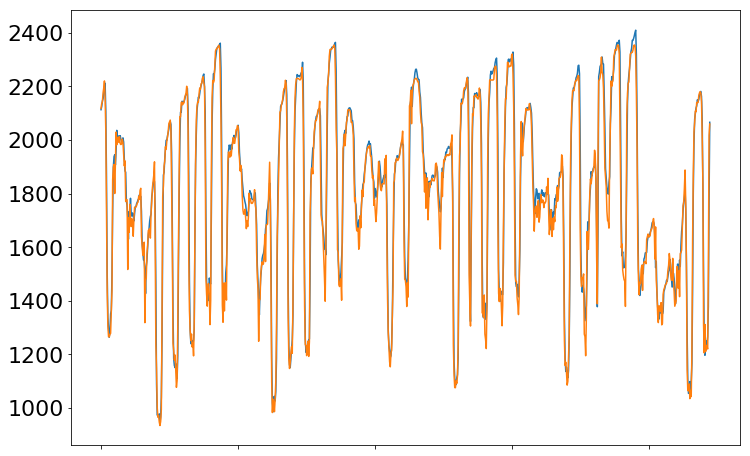

In [34]:
fig, ax = pl.subplots()
test.avail_docks.plot()
ax.plot(docks_test_hat);